In [0]:
# !pip install pycrayon

In [0]:
import os
import sys
import random
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl

from pycrayon import (
    CrayonClient,
)

from IPython import (
    display,
)

from IPython.display import (
    Image,
    clear_output,
)

# get matplotlib configuration
# %matplotlib inline
# %run plot_conf.py

In [0]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import (
    Variable,
)
from torch.nn import (
    init,
)

In [0]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import (
    Variable,
)

from torch.nn import (
    init,
)

from torchvision import (
    datasets, 
    transforms,
    models,
    utils,
)

In [0]:
# training params
batch_size = 64
num_epochs = 3
learning_rate = 0.01
dropout_p = 0.5
log_interval = 1 # epochs
num_hidden_units = 50
num_classes = 10 # MNIST
decay_rate = 0.9999
max_grad_norm = 5.0

# Use gpu
cuda = False
cuda = cuda and torch.cuda.is_available()

# reproduceability
seed = 1234
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

In [0]:
# training params
batch_size = 64
num_epochs = 3
learning_rate = 0.01
dropout_p = 0.5
log_interval = 1 # epochs
num_hidden_units = 50
num_classes = 10 # MNIST
decay_rate = 0.9999
max_grad_norm = 5.0

# Use gpu
cuda = False
cuda = cuda and torch.cuda.is_available()

# reproduceability
seed = 1234
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

In [0]:
# Train data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=False)

# Test data loader
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/mnist', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=False)

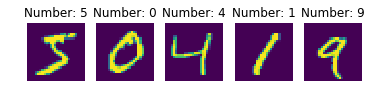

In [0]:
# Visualize some samples
batch = next(iter(train_loader))  # test_loader is an iterable
samples = batch[0][:5]
y_true = batch[1]
for i, sample in enumerate(samples):
    plt.subplot(1, 5, i+1)
    plt.title('Number: %i' % y_true[i])
    plt.imshow(sample.numpy().reshape((28,28)))
    plt.axis('off')

In [0]:
# CNN model
class CNN(nn.Module):
    """
    Simple CNN for MNIST classification.
    """
    def __init__(self, dropout_p, num_hidden_units, num_classes):
        """
        Initialization.
        """
        # super(CNN, self).__init__()  # for Python 2 
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.dropout_conv2 = nn.Dropout2d(dropout_p)
        self.fc1 = nn.Linear(320, num_hidden_units)
        self.fc2 = nn.Linear(num_hidden_units, num_classes)

    def forward(self, x):
        """
        Feed Foward.
        """
        
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.dropout_conv2(self.conv2(x)), 2))
        x = x.view(-1, 320)  # flatten
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x  # logits
    


#### conv1
$$ W2=(W1−F+2P)/S+1 = (28−5)/1+1=24 $$
$$ H2=(H1−F+2P)/S+1 = (28−5)/1+1=24 $$
$$ D2=K=10 $$
$$ torch.Size([64, 10, 24, 24]) $$

W = Width of image
H = Height of image
F = Filter size
P = padding
S = strides


#### pool1
$$ W2=(W1−F)/S+1 = (24-2)/2 + 1 = 12 $$
$$ H2=(H1−F)/S+1 = (24-2)/2 + 1 = 12 $$
$$ D2=D1=10 $$
$$ torch.Size([64, 10, 12, 12]) $$

#### conv2
$$ W2=(W1−F+2P)/S+1 = (12−5)/1+1=8 $$
$$ H2=(H1−F+2P)/S+1 = (12−5)/1+1=8 $$
$$ D2=K=20 $$
$$ torch.Size([64, 20, 8, 8]) $$

#### pool2
$$ W2=(W1−F)/S+1 = (8-2)/2 + 1 = 4 $$
$$ H2=(H1−F)/S+1 = (8-2)/2 + 1 = 4 $$
$$ D2=D1=10 $$
$$ torch.Size([64, 20, 4, 4]) $$

#### flatten the feature maps
$$ [64, 20*4*4] = [64, 320] $$

In [0]:
# Initialize model components
model = CNN(dropout_p, num_hidden_units, num_classes)
if cuda:
    model.cuda()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

In [0]:
def process_batch(inputs, targets, model, criterion, optimizer, cuda, is_training):
    """
    Process a minibatch for loss and accuracy.
    """
    
    if cuda:
        inputs, targets = inputs.cuda(), targets.cuda()
    
    # Convert tensors to Variables (for autograd)
    if is_training:
        X_batch = Variable(inputs, requires_grad=False)
    else:
        X_batch = Variable(inputs, volatile=True, requires_grad=False)
    y_batch = Variable(targets.long(), requires_grad=False)

    # Forward pass
    scores = model(X_batch) # logits

    # Loss
    loss = criterion(scores, y_batch)
    
    # Accuracy
    score, predicted = torch.max(scores, 1)
    accuracy = (y_batch.data == predicted.data).sum() / float(len(y_batch))
    
    if is_training:

        # Use autograd to do backprop. This will compute the
        # gradients w.r.t loss for all Variables that have
        # requires_grad=True. So, our w1 and w2 will now have
        # gradient components we can access.
        optimizer.zero_grad()
        loss.backward()
        
        # Clip the gradient norms
        nn.utils.clip_grad_norm(model.parameters(), max_grad_norm)

        # Update params
        optimizer.step()

    return loss, accuracy

In [0]:
def train(model, criterion, optimizer, train_loader, test_loader, 
          num_epochs, batch_size, log_interval, learning_rate,
          dropout_p, decay_rate, max_grad_norm, cuda):
    """
    Training.
    """
    
    # Metrics
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    # Training
    for num_train_epoch in range(num_epochs):

        # Timer
        start = time.time()

        # Decay learning rate
        learning_rate = learning_rate * (decay_rate ** (num_train_epoch // 1.0))
        for param_group in optimizer.param_groups:
            param_group['lr'] = learning_rate

        # Metrics
        train_batch_loss = 0.0
        train_batch_accuracy = 0.0

        for train_batch_num, (inputs, target) in enumerate(train_loader):

            # Get metrics
            try:
                model.train()
                loss, accuracy = process_batch(inputs, target, model, criterion, optimizer, cuda, model.training)

                # Add to batch scalars
                train_batch_loss += loss.data / float(len(inputs))
#                 train_batch_loss += loss.item() / float(len(inputs))
                train_batch_accuracy += accuracy
            except Exception as e: print(e)
            
        # Add to global metrics
        train_loss.append(train_batch_loss/float(train_batch_num+1))
        train_acc.append(train_batch_accuracy/float(train_batch_num+1))

        # Testing
        model.eval()
        for num_test_epoch in range(1):

            # Metrics
            test_batch_loss = 0.0
            test_batch_accuracy = 0.0

            for test_batch_num, (inputs, target) in enumerate(test_loader):

                # Get metrics
                model.eval()
                loss, accuracy = \
                    process_batch(inputs, target, model, criterion, optimizer, cuda, model.training)

                # Add to batch scalars
                test_batch_loss += loss.data / float(len(inputs))
#                 test_batch_loss += loss.item() / float(len(inputs))
                print (accuracy)
                test_batch_accuracy += accuracy

            # Add to global metrics
            test_loss.append(test_batch_loss/float(test_batch_num+1))
            test_acc.append(test_batch_accuracy/float(test_batch_num+1))
                

            verbose_condition = \
                (num_train_epoch == 0) or (num_train_epoch % log_interval == 0) or (num_train_epoch == num_epochs-1)

            # Verbose
            if verbose_condition:

                # Verbose
                time_remain = (time.time() - start) * (num_epochs - (num_train_epoch+1))
                minutes = time_remain // 60
                seconds = time_remain - minutes*60
                print("TIME REMAINING: %im %is" % (minutes, seconds))
#                 print("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACC]: %.3f, [TEST LOSS]: %.6f, [TEST ACC]: %.3f" %(num_train_epoch, train_batch_loss/float(train_batch_num+1),train_batch_accuracy/float(train_batch_num+1), test_batch_loss/float(test_batch_num+1),test_batch_accuracy/float(test_batch_num+1)))
                print("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TEST LOSS]: %.6f" %(num_train_epoch, train_batch_loss/float(train_batch_num+1), test_batch_loss/float(test_batch_num+1)))
        return model

In [0]:
model = train(model, criterion, optimizer, train_loader, test_loader, 
          num_epochs, batch_size, log_interval, learning_rate,
          dropout_p, decay_rate, max_grad_norm, cuda)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  del sys.path[0]


tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


In [0]:
def infer(model, inputs):
    """
    Inference.
    """
    if cuda:
        inputs = inputs.cuda()

    # Convert tensors to Variables (for autograd)
    X_batch = Variable(inputs, volatile=True, requires_grad=False)

    # Forward pass
    scores = model(X_batch)  # logits

    # Accuracy
    score, predicted = torch.max(scores, 1)

    return predicted

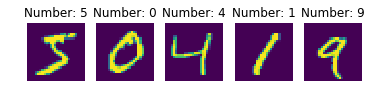

In [0]:
# ip

batch = next(iter(train_loader))  # test_loader is an iterable
samples = batch[0][:5]
y_true = batch[1]
for i, sample in enumerate(samples):
    plt.subplot(1, 5, i+1)
    plt.title('Number: %i' % y_true[i])
    plt.imshow(sample.numpy().reshape((28,28)))
    plt.axis('off')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':


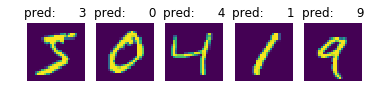

In [0]:
# title predictions
# Visualize some predictions

batch1 = next(iter(test_loader))
samples1 = batch[0][:5]
y_preds1 = infer(model, samples)

for i, sample in enumerate(samples1):
    plt1.subplot(1, 5, i+1)
    plt1.title('pred:      %i' % y_preds1[i].data)
    plt1.imshow(sample.numpy().reshape((28,28)))
    plt1.axis('off')

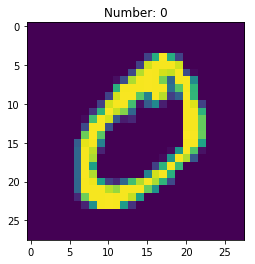

In [0]:
plt.title('Number: %i' % batch[1][1])
plt.imshow(batch[0][1].numpy().reshape((28,28)))

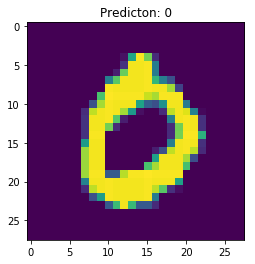

In [0]:
i=3
plt.title('Predicton: %i' % batch1[1][i])
plt.imshow(batch1[0][i].numpy().reshape((28,28)))

In [0]:
# iptnsrs=[]
# for i in range(len(batch[1])):
#     if int(batch[1][i]) == [1,2,3,4,5]:
#         optnsrs.append(batch[1][i])

In [0]:
# optnsrs=[]
# for i in range(len(batch1[1])):
#     if int(batch1[1][i]) == ['1','2','3','4','5']:
#         optnsrs.append(batch1[1][i])